In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.models import Sequential
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import keras
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import os 

In [2]:
img_height_width = [150, 150]


base_dir = r"C:/Users/utilisateur/Desktop/IA/learningCode/Projects_Simplon/AlienVsPredator/"

train_dir =  os.path.join(base_dir,"Train")
validation_dir =  os.path.join(base_dir,"Validation")
test_dir =  os.path.join(base_dir,"Test")


In [3]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=(150,150,3) , weights='imagenet', include_top=False) 
# include_top = whether to include the 3 fully-connected layers at the top of the network.
# [3] =  It should have exactly 3 input channels. 

In [4]:
# view the structure of the model
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [82]:
#train_datagen = ImageDataGenerator(rescale = 1./255)


train_datagen_aug = ImageDataGenerator(
    rotation_range=20,
    rescale=1. / 255, # rescale de image at the wirght format
    width_shift_range=0.10, # Shift the pic width by a max of 5%
    height_shift_range=0.10, # Shift the pic height by a max of 5% 
    shear_range=0.1, # Shear means cutting away part of the image (max 10%)
    zoom_range=0.1, # Zoom in by 10% max
    horizontal_flip=True, # Allo horizontal flipping
    fill_mode='nearest' # Fill in missing pixels with the nearest filled value
)

training_set = train_datagen.flow_from_directory(train_dir,
                                                 target_size = (150, 150),
                                                 batch_size = 494,
                                                 class_mode = 'binary')

val_datagen = ImageDataGenerator(rescale=1. / 255)

val_generator = val_datagen.flow_from_directory(validation_dir,
                                                    target_size=(150, 150),
                                                    batch_size=200,
                                                    class_mode='binary')

test_datagen = ImageDataGenerator(rescale = 1./255)

test_set = test_datagen.flow_from_directory(test_dir,
                                            target_size = (150, 150),
                                            batch_size=200,
                                           class_mode='binary')

Found 494 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [83]:
#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in vgg.layers:
	layer.trainable = False


In [84]:
# train à passer dans vgg16 en allant récupérer
x_train = training_set[0][0]
y_train = training_set[0][1]
x_test = test_set[0][0]
y_test = test_set[0][1]
x_val = val_generator[0][0]
y_val = val_generator[0][1]

In [85]:
x_train.shape

(494, 150, 150, 3)

In [86]:
features_train= vgg.predict(x_train).reshape(494, -1)
features_test = vgg.predict(x_test).reshape(200, -1)
features_val = vgg.predict(x_val).reshape(200, -1)

7/7 [==============================] - 29s 4s/step


In [87]:
features_train.shape

(494, 8192)

 #### Machine learning start  / Perceptron multicouche 

In [99]:
model = Sequential()
model.add(keras.layers.Dense(units=512, activation='relu', input_dim= 4 * 4 * 512)),
model.add(Flatten()) ,
model.add(keras.layers.Dense(units=270,activation='relu')),
model.add(keras.layers.Dense(units=1, activation='sigmoid'))

In [100]:
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

In [101]:
history = model.fit(features_train, y_train , epochs = 100, batch_size = 494, validation_data=( features_val, val_generator[0][1]))

Epoch 1/100
1/1 [==============================] - 1s 681ms/step - loss: 0.7010 - accuracy: 0.4737 - val_loss: 0.5502 - val_accuracy: 0.6800
Epoch 2/100
1/1 [==============================] - 0s 175ms/step - loss: 0.5222 - accuracy: 0.7105 - val_loss: 3.7284 - val_accuracy: 0.5000
Epoch 3/100
1/1 [==============================] - 0s 164ms/step - loss: 3.6300 - accuracy: 0.5000 - val_loss: 1.5512 - val_accuracy: 0.5050
Epoch 4/100
1/1 [==============================] - 0s 164ms/step - loss: 1.4278 - accuracy: 0.5223 - val_loss: 0.5264 - val_accuracy: 0.6800
Epoch 5/100
1/1 [==============================] - 0s 163ms/step - loss: 0.4854 - accuracy: 0.7348 - val_loss: 0.9476 - val_accuracy: 0.5100
Epoch 6/100
1/1 [==============================] - 0s 163ms/step - loss: 0.8918 - accuracy: 0.5081 - val_loss: 0.6223 - val_accuracy: 0.5750
Epoch 7/100
1/1 [==============================] - 0s 192ms/step - loss: 0.5857 - accuracy: 0.6113 - val_loss: 0.4170 - val_accuracy: 0.8550
Epoch 8/100
1

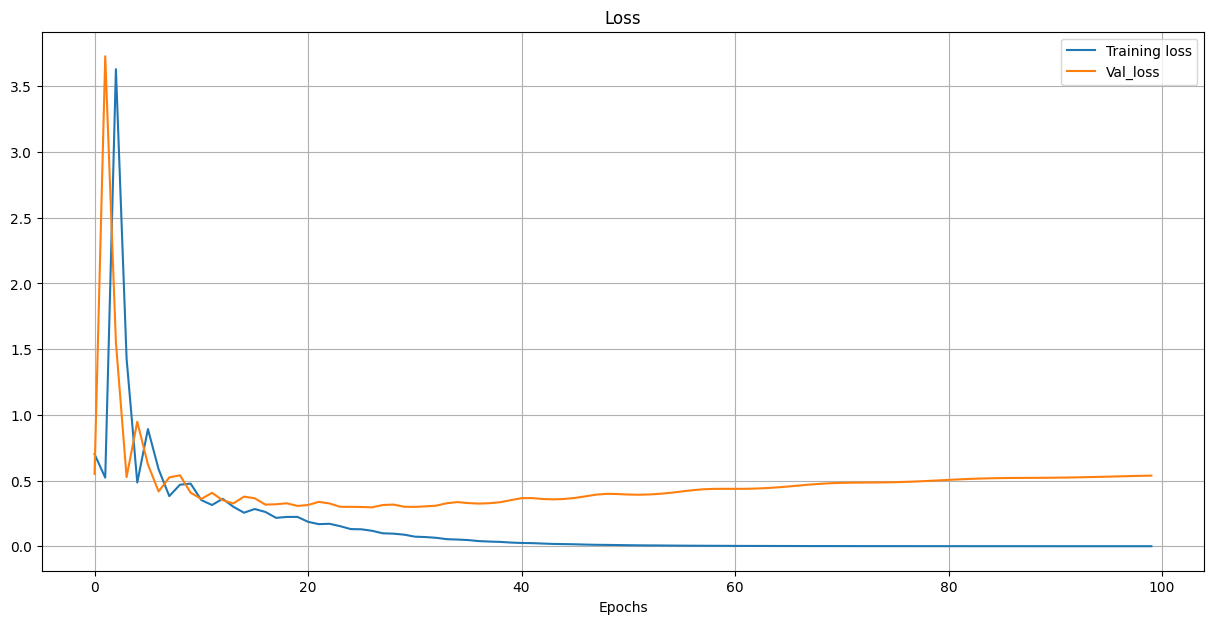

In [102]:
ax = pd.DataFrame(data=history.history).plot(y=['loss','val_loss'], figsize=(15, 7))
ax.grid()
ax.set(title="Loss", xlabel="Epochs")
ax.legend(["Training loss", "Val_loss"])
plt.show()

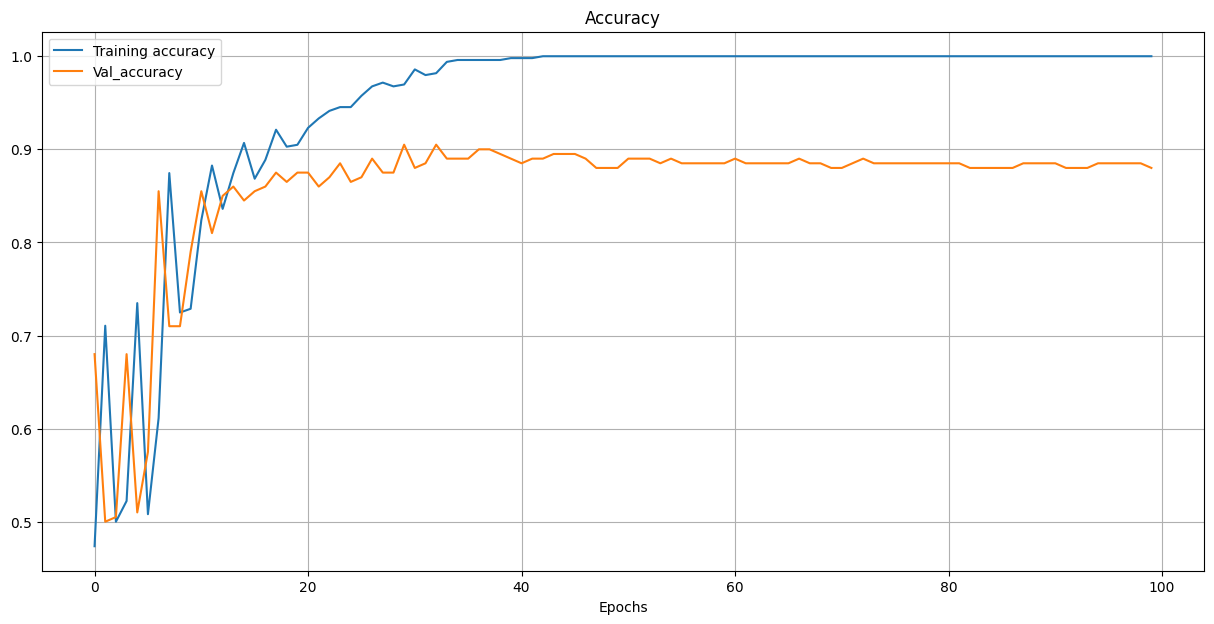

In [103]:
ax = pd.DataFrame(data=history.history).plot(y=['accuracy', 'val_accuracy'], figsize=(15, 7))
ax.grid()
ax.set(title="Accuracy", xlabel="Epochs")
ax.legend(["Training accuracy", "Val_accuracy"])
plt.show()

### Confusion Matrix / Train

16/16 [==============================] - 0s 7ms/step


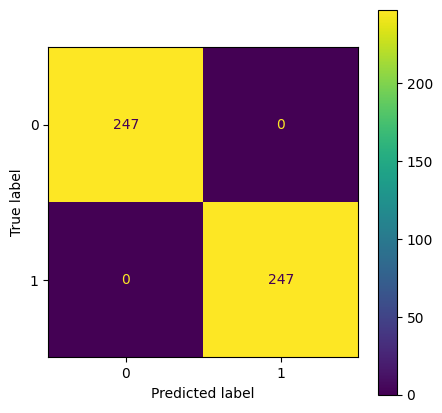

In [64]:
y_predict_train = np.where(model.predict(features_train)<0.5, 0, 1) 

display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_predict_train, y_train))
fig, ax = plt.subplots(figsize=(5,5))
display.plot(ax=ax)

plt.show()

### Confusion Matrix / Test

7/7 [==============================] - 0s 7ms/step


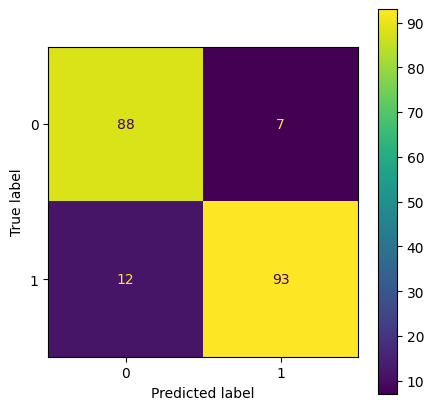

In [68]:
y_predict_test = np.where(model.predict(features_test)<0.5, 0, 1) 

display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_predict_test, y_test))
fig, ax = plt.subplots(figsize=(5,5))
display.plot(ax=ax)

plt.show()

### Confusion Matrix / Eval 

7/7 [==============================] - 0s 9ms/step


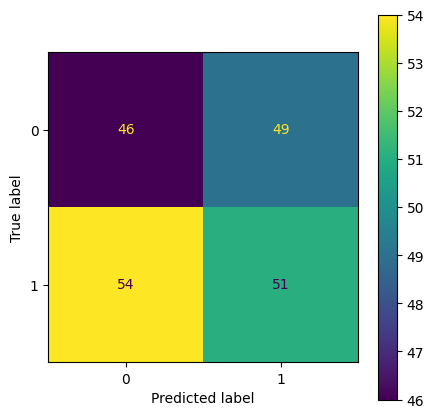

In [70]:
y_predict_val = np.where(model.predict(features_val)<0.5, 0, 1) 

display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_predict_test, y_val))
fig, ax = plt.subplots(figsize=(5,5))
display.plot(ax=ax)

plt.show()